In [1]:
import numpy as np
import pandas as pd

import os

from statsmodels.stats.api import DescrStatsW
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt

# Loading results generated from experiments

In [2]:
policies = [
    'single-fidelity ENS',
    'ucb',
    'uncertainty sampling on L, greedy on H',
    'one-step ENS limit 1000 1000 samples',
    'rep v2 shortened limit 500 500 samples',
]
policy_names = [
    'ENS',
    'MF-UCB',
    'UG',
    'H-ENS',
    'MF-ENS'
]

data_names = [
    'ecfp4',
    'gpidaph3',
    'bmg_data',
]

fprs = [70, 90]
ks = [2, 5]
budget = 300  # on H
num_exps = 50
horizon = max(ks) * budget + budget - max(ks)

basepath = '../saved_results/'

In [3]:
utilities = np.empty((
    len(policies), len(data_names), len(fprs), len(ks), num_exps, budget
))
utilities[:] = np.nan

queried_probs = np.empty((
    len(policies), len(data_names), len(fprs), len(ks), num_exps, horizon
))
queried_probs[:] = np.nan

init_data = np.empty((
    len(data_names), len(fprs), len(ks), num_exps
))
init_data[:] = np.nan

for k_ind, k in enumerate(ks):
    for fpr_ind, fpr in enumerate(fprs):
        for data_ind, data_name in enumerate(data_names):
            for policy_ind, policy in enumerate(policies):
                path = basepath + f'{budget}_{k}_{fpr}/{data_name}/{policy}/'
                
                if not os.path.isdir(path):
                    print(f'{path} does not exist')
                    continue
                
                for filename in os.listdir(path):
                    if filename.startswith(policy) and filename.endswith('.csv'):
                        name_parts = filename.split('__')
                        data_type = name_parts[1]
                        exp = int(name_parts[2]) - 1
                        init_point = int(name_parts[3])
                        
                        # assert that the initial dataset is consistent
                        if exp < num_exps:
                            if np.isnan(init_data[data_ind, fpr_ind, k_ind, exp]):
                                init_data[data_ind, fpr_ind, k_ind, exp] = init_point
                            else:
                                assert init_data[data_ind, fpr_ind, k_ind, exp] == init_point

                            data = np.loadtxt(path + filename)

                            if data_type == 'utilities':
                                utilities[policy_ind, data_ind, fpr_ind, k_ind, exp, :len(data)] = data
                            elif data_type == 'queried_probs':
                                queried_probs[policy_ind, data_ind, fpr_ind, k_ind, exp, :len(data)] = data
                            else:
                                continue

# Number of targets found

In [4]:
total_utilities = utilities.sum(axis=5)

total_utility_df = pd.DataFrame(columns=[
    'policy', 'data', 'fpr', 'k', 'utility'
])

for k_ind, k in enumerate(ks):
    for fpr_ind, fpr in enumerate(fprs):
        for data_ind, data_name in enumerate(data_names):
            for policy_ind, policy in enumerate(policies):
                total_utility_df = pd.concat([total_utility_df, pd.DataFrame({
                    'policy': policy_names[policy_ind], 'data': data_name, 'fpr': fpr, 'k': k,
                    'utility': total_utilities[policy_ind, data_ind, fpr_ind, k_ind, :]
                })])

In [5]:
mean_utility_df = total_utility_df.groupby([
    'data', 'fpr', 'k', 'policy'
]).mean().stack().unstack([0, 1, 2])
mean_utility_df

data           bmg_data                           ecfp4                  \
fpr                  70              90              70              90   
k                     2       5       2       5       2       5       2   
policy                                                                    
ENS    utility   278.16  278.16  278.82  278.82  213.18  213.18  217.66   
H-ENS  utility   284.44  285.30  289.78  294.46  223.02  230.78  240.52   
MF-ENS utility   286.00  286.04  289.66  294.08  226.32  229.96  244.08   
MF-UCB utility   273.94  276.50  284.20  289.06  200.22  206.18  227.24   
UG     utility   277.74  279.68  283.46  287.02  206.64  209.04  228.10   

data                   gpidaph3                          
fpr                          70              90          
k                    5        2       5       2       5  
policy                                                   
ENS    utility  217.66   185.56  185.56  197.18  197.18  
H-ENS  utility  249.34   202.40  221.96  220.52  245.24  
MF-ENS utility  250.48   207.84  220.52  230.04  243.10  
MF-UCB utility  238.16   187.38  199.82  200.24  211.64  
UG     utility  237.36   191.18  201.94  203.70  210.66

In [6]:
for p_id in range(len(policies) - 1):
    print(policy_names[p_id], 'vs MF-ENS')
    print(ttest_rel(total_utilities[p_id, :].flatten(), total_utilities[-1, :].flatten()).pvalue)
    print()

ENS vs MF-ENS
1.141944075027198e-45

MF-UCB vs MF-ENS
1.5943378266439172e-28

UG vs MF-ENS
4.380936204576847e-23

H-ENS vs MF-ENS
0.044290309157588595



## Average difference in cumulative reward

### vs MF-UCB

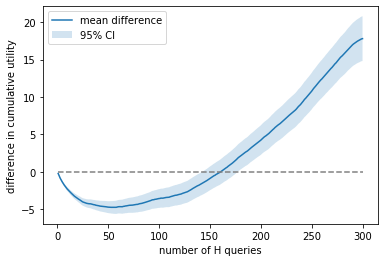

In [7]:
xs = np.arange(1, 301)

cum_utilities = utilities.cumsum(axis=5).reshape(len(policies), -1, 300)
avg_cum_utilities = cum_utilities.mean(axis=1)

p1_ind = 4
p2_ind = 1

avg_diff = avg_cum_utilities[p1_ind, :] - avg_cum_utilities[p2_ind, :]
lower_diff, upper_diff = DescrStatsW(
    cum_utilities[p1_ind, :] - cum_utilities[p2_ind, :]
).tconfint_mean()

plt.plot(xs, avg_diff, label='mean difference')
plt.fill_between(xs, lower_diff, upper_diff, alpha=0.2, label='95% CI')

plt.plot(xs, np.zeros(300), linestyle='--', c='gray')

plt.legend()

plt.xlabel('number of H queries')
plt.ylabel('difference in cumulative utility')

plt.show()

### vs UG

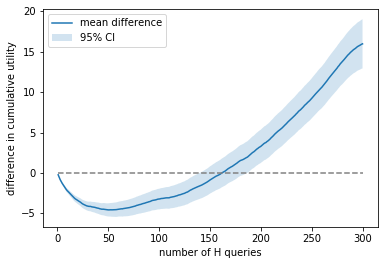

In [8]:
xs = np.arange(1, 301)

cum_utilities = utilities.cumsum(axis=5).reshape(len(policies), -1, 300)
avg_cum_utilities = cum_utilities.mean(axis=1)

p1_ind = 4
p2_ind = 2

avg_diff = avg_cum_utilities[p1_ind, :] - avg_cum_utilities[p2_ind, :]
lower_diff, upper_diff = DescrStatsW(
    cum_utilities[p1_ind, :] - cum_utilities[p2_ind, :]
).tconfint_mean()

plt.plot(xs, avg_diff, label='mean difference')
plt.fill_between(xs, lower_diff, upper_diff, alpha=0.2, label='95% CI')

plt.plot(xs, np.zeros(300), linestyle='--', c='gray')

plt.legend()

plt.xlabel('number of H queries')
plt.ylabel('difference in cumulative utility')

plt.show()

### vs ENS

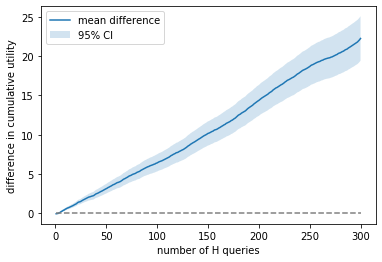

In [9]:
xs = np.arange(1, 301)

cum_utilities = utilities.cumsum(axis=5).reshape(len(policies), -1, 300)
avg_cum_utilities = cum_utilities.mean(axis=1)

p1_ind = 4
p2_ind = 0

avg_diff = avg_cum_utilities[p1_ind, :] - avg_cum_utilities[p2_ind, :]
lower_diff, upper_diff = DescrStatsW(
    cum_utilities[p1_ind, :] - cum_utilities[p2_ind, :]
).tconfint_mean()

plt.plot(xs, avg_diff, label='mean difference')
plt.fill_between(xs, lower_diff, upper_diff, alpha=0.2, label='95% CI')

plt.plot(xs, np.zeros(300), linestyle='--', c='gray')

plt.legend()

plt.xlabel('number of H queries')
plt.ylabel('difference in cumulative utility')

plt.show()

# Progressive probabilities

In [10]:
queried_probs_h = np.empty((
    len(policies), len(data_names), len(fprs), len(ks), num_exps, budget
))
queried_probs_h[:] = np.nan

for p_ind in range(len(policies)):
    for data_ind in range(len(data_names)):
        for fpr_ind in range(len(fprs)):
            for k_ind, k in enumerate(ks):
                horizon = k * (budget - 1) + budget
                
                queried_probs_h[
                    p_ind, data_ind, fpr_ind, k_ind, :, :
                ] = queried_probs[
                    p_ind, data_ind, fpr_ind, k_ind, :, :horizon:(k + 1)
                ]

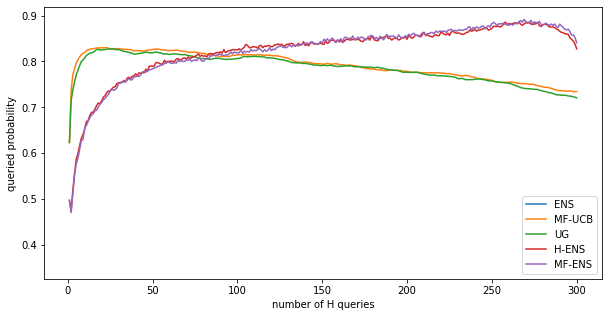

In [11]:
xs_h = np.arange(budget) + 1

plt.figure(figsize=(10, 5))

for p_ind, p_name in enumerate(policy_names):
    plt.plot(
        xs_h, queried_probs_h[p_ind].mean(axis=(0, 1, 2, 3)), 
        label=p_name
    )
    
plt.legend()
plt.xlabel('number of H queries')
plt.ylabel('queried probability')

plt.show()

# The effect of pruning

In [12]:
policies = [
    'one-step ENS limit 1000 1000 samples',
    'rep v2 shortened limit 500 500 samples',
]

policy_names = [
    'H-ENS',
    'MF-ENS'
]

limits = [
    2000,
    1000
]

computed = np.empty((
    len(policies), len(data_names), len(fprs), len(ks), num_exps, horizon
))
computed[:] = np.nan

pruned1 = np.empty((
    len(policies), len(data_names), len(fprs), len(ks), num_exps, horizon
))
pruned1[:] = np.nan

pruned2 = np.empty((
    len(policies), len(data_names), len(fprs), len(ks), num_exps, horizon
))
pruned2[:] = np.nan

init_data = np.empty((
    len(data_names), len(fprs), len(ks), num_exps
))
init_data[:] = np.nan

for fpr_ind, fpr in enumerate(fprs):
    for k_ind, k in enumerate(ks):
        for data_ind, data_name in enumerate(data_names):
            for policy_ind, policy in enumerate(policies):
                path = basepath + f'{budget}_{k}_{fpr}/{data_name}/{policy}/'

                if not os.path.isdir(path):
                    print(f'{path} does not exist')
                    continue

                for filename in os.listdir(path):
                    if filename.startswith(policy) and filename.endswith('.csv'):
                        name_parts = filename.split('__')
                        data_type = name_parts[1]
                        exp = int(name_parts[2]) - 1
                        init_point = int(name_parts[3])

                        # assert that the initial dataset is consistent
                        if exp < num_exps:
                            if np.isnan(init_data[data_ind, fpr_ind, k_ind, exp]):
                                init_data[data_ind, fpr_ind, k_ind, exp] = init_point
                            else:
                                assert init_data[data_ind, fpr_ind, k_ind, exp] == init_point

                            data = np.loadtxt(path + filename)

                            if data_type == 'computed':
                                computed[policy_ind, data_ind, fpr_ind, k_ind, exp, :len(data)] = data
                            elif data_type == 'pruned1':
                                pruned1[policy_ind, data_ind, fpr_ind, k_ind, exp, :len(data)] = data
                            elif data_type == 'pruned2':
                                pruned2[policy_ind, data_ind, fpr_ind, k_ind, exp, :len(data)] = data
                            else:
                                continue

## How often the whole pool is covered

In [14]:
all_computed = computed + pruned1 + pruned2

In [15]:
for p_ind, (p_name, limit) in enumerate(zip(policy_names, limits)):
    a = []
    
    for k_ind, k in enumerate(ks):
        horizon = k * (budget + 1) - k
        
        a.append(np.nanmean(
            all_computed[p_ind, :, :, k_ind, :, :horizon] > limit
        ))
    
    print(p_name, sum(a) / 2)

H-ENS 0.4522694444444444
MF-ENS 0.27607166666666666


## Contribution of each pruning method

In [18]:
for p_ind, (p_name, limit) in enumerate(zip(policy_names, limits)):
    b1 = []
    b2 = []
    
    for k_ind, k in enumerate(ks):
        horizon = k * (budget + 1) - k

        tmp_all_computed = all_computed[p_ind, :, :, k_ind, :, :horizon]
        tmp_pruned1 = pruned1[p_ind, :, :, k_ind, :, :horizon]
        tmp_pruned2 = pruned2[p_ind, :, :, k_ind, :, :horizon]
        mask = tmp_all_computed > limit
        
        b1.append((tmp_pruned1[mask] / tmp_all_computed[mask]).mean())
        b2.append((tmp_pruned2[mask] / tmp_all_computed[mask]).mean())
    
    print(p_name)
    print('fully pruned', sum(b1) / 2)
    print('partially pruned', sum(b2) / 2)
    print()

H-ENS
fully pruned 0.8519216003870105
partially pruned 0.13996953886470578

MF-ENS
fully pruned 0.8939540893884915
partially pruned 0.09023356266652176

